In [0]:
import numpy as np

# Torch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
import time
# Torchvision
import torchvision
import torchvision.transforms as transforms

# Matplotlib
%matplotlib inline
import matplotlib.pyplot as plt

In [25]:
import torchvision

dataset = torchvision.datasets.Omniglot(
    root="./data", download=True, transform=torchvision.transforms.ToTensor()
)
label=[]

for i in range(0,len(dataset)):
  if i==0:
    image, _ = dataset[i]
    label.append(dataset[i][1])
    
  elif dataset[i][1]!=label[-1]:
    image=torch.cat((image, dataset[i][0]), dim=0)
    label.append(dataset[i][1])

label0=[]
for i in range(0, 1000):
  if i==0:
    image=torch.cat((image, dataset[i+1][0]), dim=0)
    label0.append(dataset[i+1][1])
  elif dataset[i+1][1]!=label0[-1]:
    image=torch.cat((image, dataset[i+1][0]), dim=0)
    label0.append(dataset[i+1][1])
  if len(label0)>=1000-len(label):
    break


x_test=image.numpy()
label=np.array(label)
label0=np.array(label0)
y_test=np.concatenate((label, label0),axis=None)

import cv2
x_test_res=[]
for i in range(0,len(x_test)):
  x_test_res.append(cv2.resize(x_test[i], (28, 28)))
x_test_res=np.array(x_test_res)


Files already downloaded and verified


In [26]:
x_test_res.shape

(1000, 28, 28)

In [0]:
x_test = (x_test_res * 255).astype('int')
x_test = 255 - x_test
x_test = x_test.reshape((x_test.shape[0], 1, 28, 28))
x_test = x_test.astype('float32')

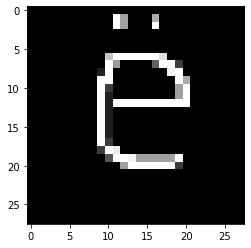

In [28]:
plt.imshow(x_test[1].reshape(28, 28), cmap = 'gray')

In [30]:
from keras.datasets import mnist

(x_train, y_train), (_, _) = mnist.load_data()
img_rows, img_cols = 28, 28
x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
# x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)


x_train = x_train.astype('float32')
print("[mnist] x_train.shape={}, y_train.shape={}".format(x_train.shape, y_train.shape))
print("[omniglot] x_test.shape={}, y_test.shape={}".format(x_test.shape, y_test.shape))

transform = transforms.Compose([transforms.ToTensor()])

trainloader_mnist = torch.utils.data.DataLoader(x_train, batch_size=64,
                                          shuffle=True, num_workers=2)

testloader_mnist = torch.utils.data.DataLoader(x_test, batch_size=64,
                                         shuffle=False, num_workers=2)

Using TensorFlow backend.


11493376/11490434 [==============================] - 1s 0us/step
[mnist] x_train.shape=(60000, 1, 28, 28), y_train.shape=(60000,)
[omniglot] x_test.shape=(1000, 1, 28, 28), y_test.shape=(1000,)


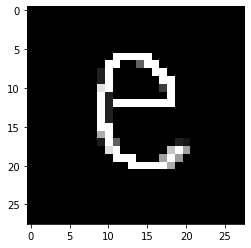

In [42]:
plt.imshow(x_test[0].reshape(28, 28), cmap = 'gray')

In [0]:
def train(epochs, net, criterion, optimizer, trainload, testloader, scheduler=None, verbose=True):
    start = time.time()
    net.to(device)
 
    for epoch in range(epochs):
        running_loss = 0.0
        net.train()
        for i, inputs_mnist in enumerate(trainload):
          
            img = Variable(inputs_mnist).to(device)
            _, outputs_mnist = net(img)
            loss = criterion(outputs_mnist, img)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.data
            
            if verbose and i % 900 == 899:
                print('[%d, %5d] loss: %.3f' %
                      (epoch + 1, i + 1, running_loss / 900))
                running_loss = 0.0

        running_loss_val = 0.0
        net.eval()
        for i, data in enumerate(testloader):

            images = data  
            images = Variable(images).to(device)
            decoded_imgs = net(images)[1]
            loss_val = criterion(decoded_imgs, images)
            running_loss_val += loss_val.data

            if verbose and i % 15 == 14:
                print('[%d, %5d] val_loss: %.3f' %
                      (epoch + 1, i + 1, running_loss_val / 15))
                running_loss_val = 0.0
        print("============================")
        if scheduler is not None:
            scheduler.step()

    end = time.time()
    print(f"Time cost for training (in seconds): {end-start}")

In [0]:
class Autoencoder3(nn.Module):
    def __init__(self,hid):
        super(Autoencoder3, self).__init__()
        
        self.encoder = nn.Sequential(
                        nn.Conv2d(1, 4, kernel_size=5),
                        nn.BatchNorm2d(4),
                        nn.ReLU(True),

                        nn.Conv2d(4, 12, kernel_size=5),
                        nn.BatchNorm2d(12),
                        nn.ReLU(True),


                        nn.Conv2d(12, 16,kernel_size=5),
                        nn.BatchNorm2d(16),
                        nn.ReLU(True),

                        nn.Conv2d(16,28, kernel_size=5),
                        nn.BatchNorm2d(28),
                        nn.ReLU(True),

                        nn.Conv2d(28, 36, kernel_size=5),
                        nn.BatchNorm2d(36),
                        nn.ReLU(True),

                        nn.Conv2d(36, hid, kernel_size=5),
                        nn.BatchNorm2d(hid),
                        nn.ReLU(True)
        )
        
        self.decoder = nn.Sequential(
                        nn.ConvTranspose2d(hid, 36, kernel_size=5),
                        nn.BatchNorm2d(36),
                        nn.ReLU(True),

                        nn.ConvTranspose2d(36, 28, kernel_size=5),
                        nn.BatchNorm2d(28),
                        nn.ReLU(True),
 
                        #nn.MaxUnpool2d(kernel_size=2),
                        nn.ConvTranspose2d(28, 16, kernel_size=5),
                        nn.ReLU(True),

                        nn.ConvTranspose2d(16, 12, kernel_size=5),
                        nn.ReLU(True),

                        nn.ConvTranspose2d(12, 4, kernel_size=5),
                        nn.ReLU(True),

                        #nn.MaxUnpool2d(kernel_size=2, stride=2),
                        nn.ConvTranspose2d(4, 1, kernel_size=5),
                        nn.ReLU(True))

        
    def forward(self,x):
        x_out = self.decoder(self.encoder(x))
        
        return _, x_out

In [0]:
from torch import device as device_
from torch.optim.lr_scheduler import StepLR

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

net = Autoencoder3(72).to(device)
optimizer2 = torch.optim.Adam(net.parameters(), weight_decay=1e-5)
epochs = 200
criterion = nn.MSELoss().to(device)

scheduler2 = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer2, epochs)

In [45]:
train(epochs, net, criterion, optimizer2, trainloader_mnist, testloader_mnist,  scheduler=scheduler2, verbose=True)

[1,   900] loss: 1279.446
[1,    15] val_loss: 1675.095
[2,   900] loss: 482.286
[2,    15] val_loss: 1410.392
[3,   900] loss: 367.128
[3,    15] val_loss: 1297.380
[4,   900] loss: 311.278
[4,    15] val_loss: 1165.155
[5,   900] loss: 277.811
[5,    15] val_loss: 1089.933
[6,   900] loss: 254.593
[6,    15] val_loss: 1043.115
[7,   900] loss: 232.933
[7,    15] val_loss: 999.239
[8,   900] loss: 218.254
[8,    15] val_loss: 957.869
[9,   900] loss: 203.673
[9,    15] val_loss: 899.810
[10,   900] loss: 193.073
[10,    15] val_loss: 846.203
[11,   900] loss: 181.802
[11,    15] val_loss: 833.561
[12,   900] loss: 172.161
[12,    15] val_loss: 806.022
[13,   900] loss: 165.806
[13,    15] val_loss: 777.030
[14,   900] loss: 157.891
[14,    15] val_loss: 750.142
[15,   900] loss: 151.867
[15,    15] val_loss: 721.983
[16,   900] loss: 145.503
[16,    15] val_loss: 696.835
[17,   900] loss: 139.485
[17,    15] val_loss: 674.431
[18,   900] loss: 135.211
[18,    15] val_loss: 656.744
[19

In [0]:
running_loss_val = 0.0
i = 0
reconstruction_time=[]
decoded_pics = []
testloader = torch.utils.data.DataLoader(x_test, batch_size=1,
                                         shuffle=False, num_workers=2)

with torch.no_grad():
    for data in testloader:
        images = data  
        images = Variable(images).to(device)
        i += 1
        encoded_imgs = net.encoder(images)
        start=time.time()
        decoded_imgs = net.decoder(encoded_imgs)
        end=time.time()
        reconstruction_time.append(end-start)
        decoded_pics.append(decoded_imgs)
        loss_val = criterion(decoded_imgs, images)
        running_loss_val += loss_val.data

In [49]:
mean=np.mean(np.array(reconstruction_time))
print(f'MSE of the tunned CNN AE on the 1000 test OMNIGLOT images trained on MNIST: {running_loss_val/i}')
print(f"Decoding time {mean} is measured in sample per seconds")

MSE of the tunned CNN AE on the 1000 test OMNIGLOT images trained on MNIST: 210.5996856689453
Decoding time 0.0006261920928955078 is measured in sample per seconds


Text(0, 0.5, '$CNN_2$')

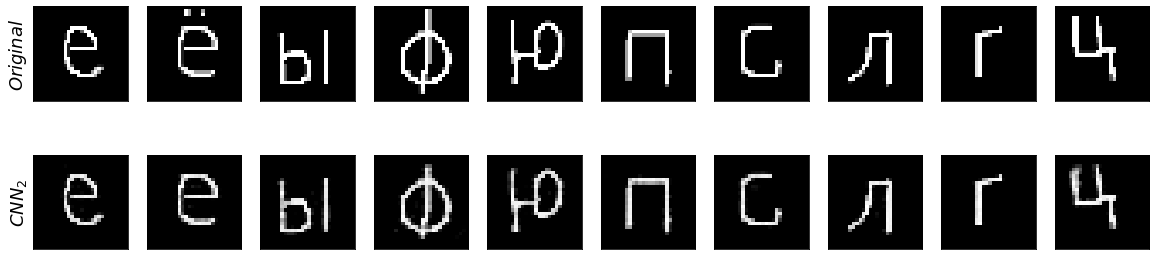

In [51]:
fig, ax = plt.subplots(ncols=10, nrows=2, figsize=(20, 5))

for X_test in testloader_mnist:
  for i in range(10):
      im = X_test[i,:]
      ax[0, i].imshow(im.numpy().reshape(28, 28).astype(int), cmap = 'gray');
      ax[1, i].imshow(decoded_pics[i].cpu().numpy().reshape(28, 28).astype(int), cmap = 'gray')
      ax[0, i].get_xaxis().set_ticks([])
      ax[0, i].get_yaxis().set_ticks([])
      ax[1, i].get_xaxis().set_ticks([])
      ax[1, i].get_yaxis().set_ticks([])


  break
ax[0, 0].set_ylabel(f"$Original$",fontsize=18)
ax[1, 0].set_ylabel(f"$CNN_2$",fontsize=18)